In [65]:
import json
import operator
from audioop import reverse
#import new
from ortools.constraint_solver._pywrapcp import new_BaseLns
from itertools import repeat
import pandas as pd

In [66]:
import math
def manhattanDistance( xy1, xy2 ):
    "Returns the Manhattan distance between points xy1 and xy2"
    return abs( xy1[0] - xy2[0] ) + abs( xy1[1] - xy2[1] )

def euclideanDistance( xy1, xy2 ):
    "Returns the Manhattan distance between points xy1 and xy2"
    return  math.sqrt(( xy2[0] - xy1[0] )**2 + ( xy2[1] - xy1[1] )**2)

def calculateRouteCost(r):
    total = 0
    for i in range(len(r) - 1):
        total+= euclideanDistance(r[i] , r[i+1])
    return total

def addDepotAtEnds(depot,route):
    route.insert(0,depot)
    route.append(depot)
    

In [67]:
pip install ortools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
df = pd.read_csv('/content/cVRPsTW250_1.csv')

In [69]:
df.head()

,ORDERID,LON,LAT,START,END,WINDOWTYPE,SERVICETIME,ORDERWEIGHT
0,0,0.0,0.0,0,0,0,0,0
1,1,-2016.0,-7990.0,20334,27534,120,300,5
2,2,-7730.0,7361.0,2134,16534,240,300,5
3,3,613.0,1256.0,4456,5656,20,300,5
4,4,7244.0,-4232.0,32230,35830,60,300,6


In [70]:
noOfCustomers = len(df["ORDERID"])
print(noOfCustomers)
customerPosDemand = dict()
vehicleCap = 50
for i in range(1,noOfCustomers):
    customerPosDemand[df["LON"][i]/1000,df["LAT"][i]/1000] = df["ORDERWEIGHT"][i]
customerPosDemand

251


{(-2.016, -7.99): 5,
 (-7.73, 7.361): 5,
 (0.613, 1.256): 5,
 (7.244, -4.232): 6,
 (8.577, -3.162): 3,
 (0.439, 4.714): 3,
 (7.043, 6.487): 4,
 (-9.627, -2.998): 4,
 (-5.048, -2.949): 5,
 (2.046, -6.507): 5,
 (-1.22, -0.865): 6,
 (-5.108, 4.388): 7,
 (5.771, 8.44): 4,
 (-4.807, -7.137): 6,
 (4.875, -9.531): 2,
 (-4.371, -2.808): 7,
 (-3.572, -3.319): 5,
 (7.282, -4.502): 6,
 (-2.123, -0.529): 7,
 (5.713, -9.343): 7,
 (3.623, -0.279): 6,
 (5.08, 5.215): 5,
 (-0.111, 2.227): 7,
 (-6.094, 1.023): 8,
 (0.851, -9.875): 4,
 (-5.467, -6.479): 7,
 (0.58, 2.809): 1,
 (-0.692, -4.312): 7,
 (-1.993, 0.491): 4,
 (-8.114, -5.89): 4,
 (9.071, 0.935): 6,
 (1.301, 5.442): 6,
 (-1.901, -9.738): 6,
 (-8.944, 6.49): 8,
 (7.72, 8.115): 6,
 (5.897, 4.752): 5,
 (-4.201, -6.165): 4,
 (-3.363, 5.885): 5,
 (8.712, -0.227): 1,
 (4.041, 8.622): 5,
 (5.993, -8.373): 4,
 (-4.439, -3.245): 10,
 (-8.41, 4.486): 4,
 (-6.843, -3.429): 3,
 (5.738, -4.19): 7,
 (1.395, 5.821): 6,
 (-9.005, 5.447): 8,
 (9.927, -5.696): 7,

In [71]:
#compute Savings for depot and i,j where i <> j
def computeSaving(depot, i,j):
    iDepot = manhattanDistance(i, depot)
    jDepot = manhattanDistance(depot, j)
    ijDist = manhattanDistance(i, j)
    
    return (iDepot + jDepot - ijDist)
    
#def distDepot


#calculating savingss for all pairs
savings = dict()
customerPositions =  list(customerPosDemand.keys())
pointsLen = len(customerPositions)
depot = (df["LON"][0]/1000,df["LAT"][0]/1000)
#print depot




def allCustomersConsidered(customerServed):
    for val in customerServed.values():
        if val == False:
            return False
    return True
        

#Step 1
distanceDict = dict()
for i in range(pointsLen):
    for j in range(i+1,pointsLen):
      #print()
      distanceDict[(customerPositions[i], customerPositions[j])] = euclideanDistance(customerPositions[i], customerPositions[j])

#Step 2
for i in range(pointsLen):
    for j in range(i+1,pointsLen):
        savings[(customerPositions[i], customerPositions[j])] = computeSaving(depot,customerPositions[i], customerPositions[j])
savings = sorted(savings.items(),key=operator.itemgetter(1),reverse=True)
l = len(savings)
cust_pairs = list()
for i in range(l):
    cust_pairs.append(savings[i][0])

#initially none of the customers have been isServed
customerServed = dict()
for c in customerPositions:
    customerServed[c] = False


#Step 3
def inPrevious(new,existing):
    start = existing[0]
    end = existing[len(existing)-1]
    if new == start:
        return 1
    elif new == end:
        return 0
    else:
        return -1

def capacityValid(existing,new):
    totalCap = customerPosDemand[new]
    for c in existing:
        totalCap+=customerPosDemand[c]

    return totalCap <= vehicleCap

def isServed(c):
    return customerServed[c]

def hasBeenServed(c):
    customerServed[c] = True             
     
routes = dict()
l = len(cust_pairs)
i = 0
idx = -1
truck = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]

while (not(allCustomersConsidered(customerServed))):
    #choosing the maximum savings customers who are unserved
    for c in cust_pairs:
        if (isServed(c[0]) == False and isServed(c[1]) == False):
            hasBeenServed(c[0])
            hasBeenServed(c[1])
            idx += 1
            routes[idx] = ([c[0],c[1]]) 
            break
        
    #finding a cust that is either at the start or end of previous route
    for c in cust_pairs:
        res = inPrevious(c[0], routes[idx])
        if res == 0 and capacityValid(routes[idx], c[1]) and (isServed(c[1]) == False):
            if c[1] == (13,7):
                print(customerServed[c[1]])
            hasBeenServed(c[1])
            routes[idx].append(c[1]) 
        elif res == 1 and capacityValid(routes[idx], c[1]) and (isServed(c[1]) == False):
            if c[1] == (13,7):
                print(customerServed[c[1]])
            hasBeenServed(c[1])
            routes[idx].insert(0,c[1])
        
        else:
            res = inPrevious(c[1], routes[idx])
            if res == 0 and capacityValid(routes[idx], c[0]) and (isServed(c[0]) == False):
                if c[0] == (13,7):
                    print(customerServed[c[0]])
                hasBeenServed(c[0])
                routes[idx].append(c[0]) 
            elif res == 1 and capacityValid(routes[idx], c[0]) and (isServed(c[0]) == False):
                if c[0] == (13,7):
                    print(customerServed[c[0]])
                hasBeenServed(c[0])
                routes[idx].insert(0,c[0])





In [72]:
for r in routes.values():
    for point in r:
        print(point)

# printing each truck load
for r in routes.values():
    cap = 0
    for points in r:
        cap += customerPosDemand[points]


#adding depot at ends
for r in routes.values():
    addDepotAtEnds(depot, r)

totalDist = 0
for k,v in routes.items():
    totalDist += calculateRouteCost(v)
    #print(k,"-",v)
print(totalDist)

(7.043, 6.487)
(7.337122926312469, 6.30475008256663)
(7.3661201413520505, 7.1211478935024894)
(7.72, 8.115)
(8.14725346263602, 7.573651680715691)
(8.33060829350783, 7.44382562937783)
(8.05279944242323, 6.921060708642179)
(8.2011578637486, 6.54796469757361)
(8.06622170229738, 6.3956536393402805)
(7.83496828872153, 6.3610929792607305)
(8.01528399093548, 5.981929139216479)
(8.577, -3.162)
(8.791, -5.578)
(8.084249454764901, -5.22744393288919)
(9.927, -5.696)
(7.8625805648546505, -6.63231071935874)
(7.90423782528974, -6.99627531819731)
(6.9314732215019506, -7.84449987302434)
(5.993, -8.373)
(4.875, -9.531)
(5.39217062797244, -7.06166231875494)
(0.485745629769111, 3.60126100482641)
(-1.43338232181362, 6.57255310200527)
(-3.363, 5.885)
(-4.01689430389613, 5.71399238037135)
(-7.73, 7.361)
(-8.944, 6.49)
(-9.005, 5.447)
(-8.41, 4.486)
(-5.108, 4.388)
(7.33185153697867, 4.4424264062359295)
(7.368242203591439, 4.82551803618884)
(7.45813832304417, 4.99099424119742)
(7.71011487539064, 5.3270757688

In [73]:
#routes.items()

In [74]:
import matplotlib.pyplot as plt
import numpy as np

In [75]:
colors = [np.random.rand(3) for i in range(len(df['ORDERID']))]

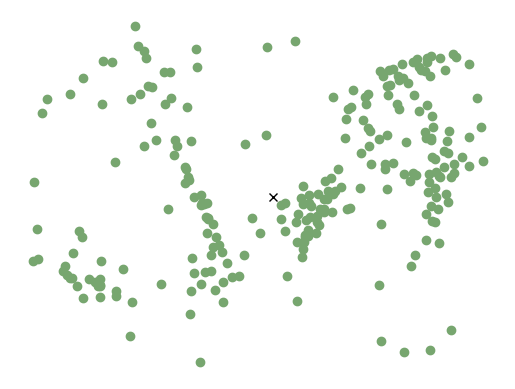

In [76]:
for i in df['ORDERID']:
  if i==0:
    plt.plot(df['LAT'][0],df['LON'][0],'x',color='black')
  else:
    plt.plot(df['LAT'][i],df['LON'][i],'o',color=colors[1])
plt.gca().axis('off');

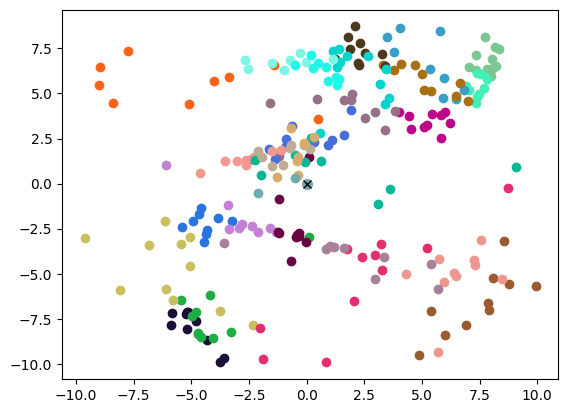

In [78]:
colors = [np.random.rand(3) for i in range(len(df))]
for ii in routes.keys():
  
  for jj in routes[ii]:
    #print(jj)
    plt.plot(jj[0],jj[1],'o',color=colors[ii])
plt.plot(df['LAT'][0],df['LON'][0],'x',color='black')
plt.show()

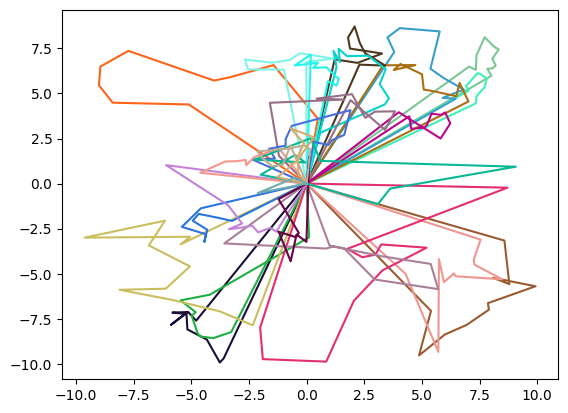

In [79]:
for jj in routes.keys():
  x= [ii[0] for ii in routes[jj]]
  x.append(0)
  y= [ii[1] for ii in routes[jj]]
  y.append(0)
  plt.plot(x,y,color=colors[jj])